In [ ]:
!pip install lightgbm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pandas as pd
import cv2
import os
from keras.applications.densenet import DenseNet169
from keras.applications.mobilenet import MobileNet
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
from matplotlib.backends.backend_pdf import PdfPages

from google.colab import drive
from google.colab import files
import zipfile

In [ ]:

# Step 1: Mount the zip file from your local machine
# drive.mount('/content/drive', force_remount = True)

zip_path = '/content/drive/COVID-19-master.zip'

extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the extracted folder structure
os.listdir(extract_path)


# Set your dataset path
DATASET_PATH = "/content/dataset/COVID-19-master/Dataset"

BadZipFile: File is not a zip file

## loading the dataset

In [ ]:
SIZE = 224
images = []
images_labels = []

### importing each image and set the current directory name as its label

In [ ]:
ext = ['png', 'jpg', 'jpeg']

for directory_path in glob.glob(DATASET_PATH+ "/*"):
    splitted = directory_path.split("/")
    label = splitted[-1]
    print(label)
    for e in ext:
        for img_path in glob.glob(os.path.join(directory_path, "*." + e)):
            if label == 'Pneumonia':
                break
            else:
                # print(img_path)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (SIZE, SIZE))
                images.append(img)
                images_labels.append(label)

No_findings
Covid-19
Pneumonia


In [ ]:
images = np.array(images)
images_labels = np.array(images_labels)

In [ ]:
images.shape

(1250, 224, 224, 3)

In [ ]:
np.unique(images_labels)

array(['Covid-19', 'No_findings'], dtype='<U11')

## Pre-processing

### label encoding

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(images_labels)
labels_encoded = le.transform(images_labels)

## Feature Extraction

### DenseNet169

In [ ]:
dense_model = DenseNet169(
    include_top=False, input_shape=(SIZE, SIZE, 3), pooling='avg')

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
dense_features = dense_model.predict(images)

40/40 [==============================] - 30s 686ms/step


In [ ]:
features = dense_features.reshape(dense_features.shape[0], -1)

In [ ]:
features.shape

(1250, 1664)

### Mobilenet

In [ ]:
model_mobile = MobileNet(weights='imagenet', include_top=False,
                         input_shape=(SIZE, SIZE, 3), pooling='avg')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_features = model_mobile.predict(images)

40/40 [==============================] - 6s 151ms/step


In [ ]:
features_2 = mobile_features.reshape(mobile_features.shape[0], -1)

In [ ]:
features_2.shape

(1250, 1024)

## Feature Combination

In [ ]:
combined_features = np.hstack((dense_features, mobile_features))

In [ ]:
combined_features.shape

(1250, 2688)

## lightgbm classifier

In [ ]:
params = {'learning_rate': 0.2, 'n_iterations': 500, 'max_depth': 7,
          'num_leaves': 105, 'n_estimators': 300, 'min_child_samples': 40}

In [ ]:
lgb_classifier = lgb.LGBMClassifier(**params)

## Feature Selection

In [ ]:
selected_features = SelectKBest(chi2, k=2000).fit_transform(
    combined_features, labels_encoded)

In [ ]:
selected_features.shape

(1250, 2000)

## KFold cross validation

In [ ]:
accuracy_per_fold = {}

for i in range(0, 10):
    kf = KFold(n_splits=5, random_state=i, shuffle=True)
    accuracy = cross_val_score(
        lgb_classifier, selected_features, labels_encoded, cv=kf, scoring='accuracy')
    accuracy_per_fold[i] = np.mean(accuracy)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training

In [ ]:
# finding the random state with the highest accuracy
for key, value in accuracy_per_fold.items():
    if value == max(accuracy_per_fold.values()):
        print(key)

1
2


## Confusion matrix

In [ ]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
cm = {}
key = 1
accuracy = {}

for train, test in kf.split(selected_features):
    x_train, x_test = selected_features[train], selected_features[test]
    y_train, y_test = labels_encoded[train], labels_encoded[test]

    lgb_classifier.fit(x_train, y_train)
    cm[key] = confusion_matrix(y_test, lgb_classifier.predict(x_test))
    accuracy[key] = accuracy_score(y_test, lgb_classifier.predict(x_test))
    key += 1

[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Info] Number of positive: 789, number of negative: 211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431444
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1975
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.789000 -> initscore=1.318908
[LightGBM] [Info] Start training from score 1.318908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [ ]:
accuracy

{1: 1.0, 2: 0.992, 3: 1.0, 4: 1.0, 5: 1.0}

## Confusion matrix HeatMap

<Figure size 3000x2000 with 0 Axes>

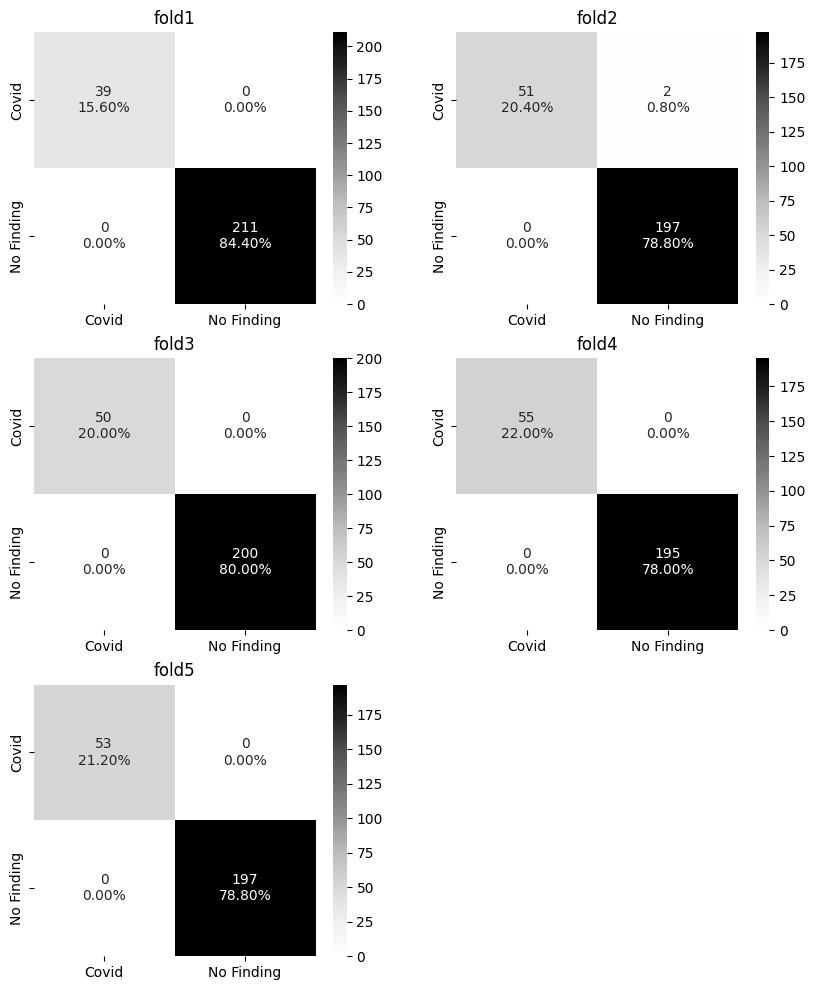

In [ ]:
key = 1
plt.figure(figsize=(30, 20))
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
fig.delaxes(axs[2, 1])
categories = ['Covid', 'No Finding']

for i in range(3):
    for j in range(2):
        if key in range(1, 6):
            counts = ['{0:0.0f}'.format(value) for value in
                      cm[key].flatten()]
            group_percentages = ['{0:.2%}'.format(value) for value in
                                 cm[key].flatten()/np.sum(cm[key])]
            labels = [f'{v1}\n{v2}' for v1, v2 in
                      zip(counts, group_percentages)]
            labels = np.asarray(labels).reshape(2, 2)

            sns.heatmap(cm[key], ax=axs[i, j], annot=labels, fmt='',
                        xticklabels=categories, yticklabels=categories, cmap='Greys')
            axs[i, j].set_title(f'fold{key}')
            key += 1

In [ ]:
pp = PdfPages("heatmap.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

## Performance checking

In [ ]:
def confusion_metrics(cm):
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sensitivity = TP / (FN + TP)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    result = {'Sensitivity': sensitivity*100, 'Specificity': specificity *
              100, 'Precision': precision*100, 'F1-Score': f1_score*100}
    return result

In [ ]:
performance = pd.DataFrame(
    columns=['Folds', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'Accuracy'])
performance

,Folds,Sensitivity,Specificity,Precision,F1-Score,Accuracy


In [ ]:
for index in range(1, 6):
    cf = cm[index]
    metrics = confusion_metrics(cf)
    all_in_one = {**{'Folds': f'fold {index}'}, **
                  metrics, **{'Accuracy': accuracy[index]*100}}
    performance = performance.append(all_in_one, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
performance

,Folds,Sensitivity,Specificity,Precision,F1-Score,Accuracy
0,fold 1,100.000000,100.000000,100.000000,100.000000,100.0
1,fold 2,98.979592,88.888889,97.000000,97.979798,96.8
2,fold 3,99.065421,100.000000,100.000000,99.530516,99.2
3,fold 4,100.000000,86.956522,97.142857,98.550725,97.6
4,fold 5,100.000000,92.000000,98.039216,99.009901,98.4


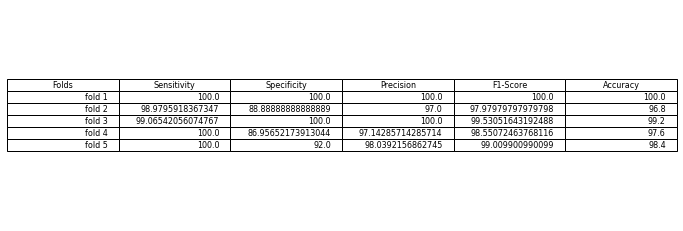

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=performance.values,
                     colLabels=performance.columns, loc='center')

pp = PdfPages("confusion_metrics.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()